## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
import datetime as dt

import sklearn
import sklearn.metrics as metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 500)
%matplotlib inline

In [2]:
# import tensorflow as tf
# print("tf version = ", tf.__version__)
# with tf.device("/gpu:0"):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)
# with tf.Session() as sess:
#     print (sess.run(c))

## Read data

In [3]:
admin = pd.read_csv('../AirTracks/all_csv/Jan2017/admin.csv')

In [4]:
admin.head(2)

,FlightId,FlightCallsign,AircraftModel,AircraftRegistration,Airline,Origin,Destination,SchdeuledDeparture,ScheduledArrival,RealDeparture,EstimatedArrival,FlightTime
0,c244ac4,SAS1749,ATR 72-600,OY-JZE,SAS,Tallinn Lennart Meri Airport,Stockholm Arlanda Airport,1.484156e+09,1.484161e+09,1.484159e+09,NaN,3762.0
1,c32d217,OKA2925,Boeing 737-8AS,B-5578,OKAir,Changsha Huanghua International Airport,Hangzhou Xiaoshan International Airport,1.484694e+09,1.484698e+09,1.484694e+09,1.484698e+09,3850.0


## Rename columns

In [5]:
admin.rename(columns={
    'FlightId': 'flight_id',
    'FlightCallsign': 'flight_callsign',
    'AircraftModel': 'aircraft_model',
    'AircraftRegistration': 'aircraft_registration',
    'SchdeuledDeparture': 'scheduled_departure_utc',
    'ScheduledArrival': 'scheduled_arrival_utc',
    'RealDeparture': 'real_departure_utc',
    'EstimatedArrival': 'estimated_arrival_utc',
    'FlightTime': 'real_flight_duration'
     }, inplace=True)

admin.columns = admin.columns.map(lambda x: x.lower())

In [6]:
admin.columns

Index(['flight_id', 'flight_callsign', 'aircraft_model',
       'aircraft_registration', 'airline', 'origin', 'destination',
       'scheduled_departure_utc', 'scheduled_arrival_utc',
       'real_departure_utc', 'estimated_arrival_utc', 'real_flight_duration'],
      dtype='object')

In [7]:
admin.dtypes

flight_id                   object
flight_callsign             object
aircraft_model              object
aircraft_registration       object
airline                     object
origin                      object
destination                 object
scheduled_departure_utc    float64
scheduled_arrival_utc      float64
real_departure_utc         float64
estimated_arrival_utc      float64
real_flight_duration       float64
dtype: object

## Handling null data

In [8]:
admin.isnull().sum()

flight_id                       0
flight_callsign              3851
aircraft_model              18818
aircraft_registration       20741
airline                     24109
origin                      41361
destination                 88792
scheduled_departure_utc     23538
scheduled_arrival_utc       23538
real_departure_utc          64318
estimated_arrival_utc      502967
real_flight_duration       160380
dtype: int64

In [9]:
admin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158127 entries, 0 to 1158126
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   flight_id                1158127 non-null  object 
 1   flight_callsign          1154276 non-null  object 
 2   aircraft_model           1139309 non-null  object 
 3   aircraft_registration    1137386 non-null  object 
 4   airline                  1134018 non-null  object 
 5   origin                   1116766 non-null  object 
 6   destination              1069335 non-null  object 
 7   scheduled_departure_utc  1134589 non-null  float64
 8   scheduled_arrival_utc    1134589 non-null  float64
 9   real_departure_utc       1093809 non-null  float64
 10  estimated_arrival_utc    655160 non-null   float64
 11  real_flight_duration     997747 non-null   float64
dtypes: float64(5), object(7)
memory usage: 106.0+ MB


In [10]:
# Drop rows where both origin and destination are NaN
# admin[~(admin['origin'].isnull() & admin['destination'].isnull())]

# Drop rows where either origin and destination are NaN
# admin.dropna(subset=['origin', 'destination'], inplace=True)

In [11]:
# ls_object_columns = admin.loc[:, admin.dtypes == object].columns.tolist()
str_cols = admin.columns[admin.dtypes==object]

In [12]:
# Fill NaN with empty string
admin[str_cols] = admin[str_cols].fillna('')

In [13]:
# Strip leading and trailing spaces in object columns
admin[str_cols] = admin[str_cols].apply(lambda x: x.str.strip())

In [14]:
# Drop duplicates
print(admin.shape)
admin.drop_duplicates(inplace=True)
print(admin.shape)

(1158127, 12)
(1158127, 12)


## Convert to datetime

In [15]:
def get_utc_datetime(value):
    try:
        return dt.datetime.fromtimestamp(value)
    except:
        return pd.NaT
    
admin['scheduled_departure_dt'] = admin['scheduled_departure_utc'].map(get_utc_datetime)
admin['scheduled_arrival_dt'] = admin['scheduled_arrival_utc'].map(get_utc_datetime)
admin['real_departure_dt'] = admin['real_departure_utc'].map(get_utc_datetime)
admin['estimated_arrival_dt'] = admin['estimated_arrival_utc'].map(get_utc_datetime)

**scheduled_arrival_utc, scheduled_departure_utc**

In [16]:
admin['scheduled_arrival_dt'][:5]

0   2017-01-12 02:55:00
1   2017-01-18 08:15:00
2   2017-01-18 06:55:00
3   2017-01-19 16:00:00
4   1970-01-01 07:30:00
Name: scheduled_arrival_dt, dtype: datetime64[ns]

In [17]:
admin['scheduled_departure_dt'][:5]

0   2017-01-12 01:40:00
1   2017-01-18 06:55:00
2   2017-01-18 02:40:00
3   2017-01-19 13:35:00
4   1970-01-01 07:30:00
Name: scheduled_departure_dt, dtype: datetime64[ns]

Observation: There are some dates where year = 1970. Check if there are dates that do not fall within Jan 2017

In [18]:
admin['scheduled_arrival_year'] = admin['scheduled_arrival_dt'].dt.year.astype('Int64')
admin['scheduled_arrival_month'] = admin['scheduled_arrival_dt'].dt.month.astype('Int64')
admin['scheduled_arrival_day'] = admin['scheduled_arrival_dt'].dt.day.astype('Int64')

In [19]:
admin['scheduled_departure_year'] = admin['scheduled_departure_dt'].dt.year.astype('Int64')
admin['scheduled_departure_month'] = admin['scheduled_departure_dt'].dt.month.astype('Int64')
admin['scheduled_departure_day'] = admin['scheduled_departure_dt'].dt.day.astype('Int64')

In [20]:
# admin.loc[(admin['scheduled_arrival_dt'].dt.year == 1970) & (admin['real_departure_dt'].notnull())].shape

admin['scheduled_arrival_year'].value_counts(dropna=False).sort_index()

admin['scheduled_arrival_month'].value_counts(dropna=False).sort_index()

admin['scheduled_arrival_day'].value_counts(dropna=False).sort_index()

admin['scheduled_departure_year'].value_counts(dropna=False).sort_index()

admin['scheduled_departure_month'].value_counts(dropna=False).sort_index()

admin['scheduled_departure_day'].value_counts(dropna=False).sort_index()

admin['scheduled_arrival_dt'].isnull().sum()

admin['scheduled_departure_dt'].isnull().sum()

In [21]:
schedule_arrival_missing_index = admin.loc[admin['scheduled_arrival_dt'].isnull(), 'scheduled_arrival_dt'].index.tolist()
# # returns the same result
# admin['ScheduledArrival'][admin['ScheduledArrival'].isnull()].index

In [22]:
schedule_departure_missing_index = admin.loc[admin['scheduled_departure_dt'].isnull(), 'scheduled_departure_dt'].index.tolist()

In [23]:
np.array_equal(schedule_departure_missing_index, schedule_arrival_missing_index)

True

Observation: Rows with NaT for scheduled_arrival_dt also had NaT for scheduled_departure_dt

In [24]:
estimated_arrival_missing_index = admin.loc[admin['estimated_arrival_dt'].isnull(), 'estimated_arrival_dt'].index.tolist()

In [25]:
len(estimated_arrival_missing_index)

502967

In [26]:
len(list(set(estimated_arrival_missing_index).intersection(set(schedule_departure_missing_index))))

23538

Observation: EstimatedArrival shares common missing values for ScheduledArrival and ScheduledDeparture

In [27]:
# # Calculate scheduled flight time in timedelta type
# admin['scheduled_flight_time'] = admin['scheduled_arrival'] - admin['scheduled_departure']

# # Convert scheduled flight time from timedelta to seconds
# admin['scheduled_flight_time'] = admin['scheduled_flight_time'].map(lambda x: x.total_seconds())

In [28]:
admin['scheduled_flight_duration'] = admin['scheduled_arrival_utc'] - admin['scheduled_departure_utc']

**real_departure**

In [29]:
admin['real_departure_dt'].dt.year.value_counts(dropna=False)

2017.0    1090758
NaN         64318
2016.0       3051
Name: real_departure_dt, dtype: int64

In [30]:
admin.dropna(subset=['real_departure_dt'], inplace=True)

**real_flight_duration**

In [31]:
admin.dtypes

flight_id                            object
flight_callsign                      object
aircraft_model                       object
aircraft_registration                object
airline                              object
origin                               object
destination                          object
scheduled_departure_utc             float64
scheduled_arrival_utc               float64
real_departure_utc                  float64
estimated_arrival_utc               float64
real_flight_duration                float64
scheduled_departure_dt       datetime64[ns]
scheduled_arrival_dt         datetime64[ns]
real_departure_dt            datetime64[ns]
estimated_arrival_dt         datetime64[ns]
scheduled_arrival_year                Int64
scheduled_arrival_month               Int64
scheduled_arrival_day                 Int64
scheduled_departure_year              Int64
scheduled_departure_month             Int64
scheduled_departure_day               Int64
scheduled_flight_duration       

In [32]:
# (admin['estimated_arrival'] - admin['real_departure'])[1].total_seconds()
(admin['estimated_arrival_utc'] - admin['real_departure_utc'])[1]

4135.0

In [33]:
admin.shape

(1093809, 23)

In [34]:
admin['real_flight_duration'].isnull().sum()

119761

In [35]:
real_flight_duration_null_idx = admin[admin['real_flight_duration'].isnull()].index.tolist()

In [36]:
real_departure_null_idx = admin[admin['real_departure_utc'].isnull()].index.tolist()

In [37]:
print(len(real_flight_duration_null_idx))
len(real_departure_null_idx)

119761


0

In [38]:
len(set(real_flight_duration_null_idx).intersection(real_departure_null_idx))

0

In [39]:
# admin.dropna(subset=['flight_time'], inplace=True)

In [40]:
# admin['real_departure'].isnull().sum()flight_time_null_idx

In [41]:
# def get_h_m_s(value):
#     h = value // 3600
#     m = value % 3600 // 60
#     s = value % 60
#     try:
#         return int(h), int(m), int(s)
#     except:
#         return np.nan

In [42]:
# admin['flight_time'].apply(get_h_m_s)

In [43]:
# import datetime
# str(datetime.timedelta(seconds=7144))

In [44]:
# # Reference: https://stackoverflow.com/questions/775049/how-do-i-convert-seconds-to-hours-minutes-and-seconds
# m, s = divmod(7144, 60)
# h, m = divmod(m, 60)
# h, m, s

In [45]:
# # Reference: https://stackoverflow.com/questions/1384406/convert-seconds-to-hhmmss-in-python
# s = 7144
# m = s // 60
# h = m // 60
# h, m%60, s%60

## Analysis of a single flight (flight_id = c244ac4)

In [46]:
# admin.columns

In [47]:
# admin[admin.flight_id == 'c244ac4']

In [48]:
# str(dt.timedelta(seconds=admin.loc[admin.flight_id == 'c244ac4', 'real_flight_duration'].values[0]))

## Route

In [49]:
admin['route'] = admin.origin + " -> " + admin.destination

In [50]:
admin['route'].value_counts()[:20]

 ->                                                                                              13376
Seoul Gimpo International Airport -> Jeju International Airport                                   2039
Jeju International Airport -> Seoul Gimpo International Airport                                   1961
Sydney Kingsford Smith Airport -> Melbourne Airport                                               1553
Melbourne Airport -> Sydney Kingsford Smith Airport                                               1452
Ho Chi Minh City International Airport -> Hanoi Noi Bai International Airport                     1447
Hanoi Noi Bai International Airport -> Ho Chi Minh City International Airport                     1397
Delhi Indira Gandhi International Airport -> Mumbai Chhatrapati Shivaji International Airport     1230
Mumbai Chhatrapati Shivaji International Airport -> Delhi Indira Gandhi International Airport     1191
Taiwan Taoyuan International Airport -> Hong Kong International Airport  

In [51]:
# admin.dropna(subset=['real_flight_duration']).isnull().sum()

In [52]:
admin.isnull().sum()

flight_id                         0
flight_callsign                   0
aircraft_model                    0
aircraft_registration             0
airline                           0
origin                            0
destination                       0
scheduled_departure_utc           0
scheduled_arrival_utc             0
real_departure_utc                0
estimated_arrival_utc        448716
real_flight_duration         119761
scheduled_departure_dt            0
scheduled_arrival_dt              0
real_departure_dt                 0
estimated_arrival_dt         448716
scheduled_arrival_year            0
scheduled_arrival_month           0
scheduled_arrival_day             0
scheduled_departure_year          0
scheduled_departure_month         0
scheduled_departure_day           0
scheduled_flight_duration         0
route                             0
dtype: int64

In [53]:
mask = admin['route'] == 'Taiwan Taoyuan International Airport -> Hong Kong International Airport'
df_twn_hkg = admin[mask]

In [54]:
df_twn_hkg.sort_values(by='scheduled_departure_dt')['scheduled_departure_dt'].head(32)

93302     1970-01-01 07:30:00
337403    1970-01-01 07:30:00
789218    1970-01-01 07:30:00
509209    1970-01-01 07:30:00
113366    1970-01-01 07:30:00
315696    1970-01-01 07:30:00
311509    1970-01-01 07:30:00
959131    1970-01-01 07:30:00
757536    1970-01-01 07:30:00
1102567   1970-01-01 07:30:00
730102    1970-01-01 07:30:00
266773    1970-01-01 07:30:00
554909    1970-01-01 07:30:00
254181    1970-01-01 07:30:00
749480    1970-01-01 07:30:00
1069647   1970-01-01 07:30:00
1069001   1970-01-01 07:30:00
930360    1970-01-01 07:30:00
138451    1970-01-01 07:30:00
268583    1970-01-01 07:30:00
24196     1970-01-01 07:30:00
1104197   1970-01-01 07:30:00
1060331   1970-01-01 07:30:00
469801    1970-01-01 07:30:00
1034334   1970-01-01 07:30:00
833060    1970-01-01 07:30:00
431010    1970-01-01 07:30:00
708040    1970-01-01 07:30:00
957928    1970-01-01 07:30:00
17778     1970-01-01 07:30:00
792492    1970-01-01 07:30:00
369045    2016-12-31 22:00:00
Name: scheduled_departure_dt, dtype: dat

In [55]:
# 31 scheduled_departure in 1970
# df_twn_hkg['scheduled_departure_dt'].sort_values()[:32]

In [56]:
# 31 scheduled_arrival in 1970
# df_twn_hkg['scheduled_arrival_dt'].sort_values()[:32]

In [57]:
df_twn_hkg[df_twn_hkg['scheduled_departure_dt'].isnull()].index

Int64Index([], dtype='int64')

In [58]:
# df_twn_hkg.loc[841654]

In [59]:
df_twn_hkg[df_twn_hkg['real_flight_duration'].isnull()].index

Int64Index([  24196,  131209,  254181,  266773,  268583,  431010,  509209,
             631005,  708040,  792492,  833060,  860491,  930360,  957928,
             959131, 1034334, 1060331, 1069001, 1104197, 1157632],
           dtype='int64')

In [60]:
# (df_twn_hkg['scheduled_arrival_year'].dropna().astype(int).astype(str) + '-' + \
# df_twn_hkg['scheduled_arrival_month'].dropna().astype(int).astype(str) + '-' + \
# df_twn_hkg['scheduled_arrival_day'].dropna().astype(int).astype(str)) \
# .value_counts() \
# .sort_index()
df_twn_hkg['scheduled_arrival_dt'].dt.date.value_counts(dropna=False).sort_index()

1970-01-01    31
2016-12-31     1
2017-01-01    35
2017-01-02    36
2017-01-03    38
2017-01-04    33
2017-01-05    39
2017-01-06    42
2017-01-07    31
2017-01-08    26
2017-01-09     6
2017-01-10    11
2017-01-11    36
2017-01-12    38
2017-01-13    12
2017-01-14    39
2017-01-15    48
2017-01-16    35
2017-01-17    43
2017-01-18    42
2017-01-19    37
2017-01-20    37
2017-01-21    46
2017-01-22    36
2017-01-23    39
2017-01-24    43
2017-01-25    44
2017-01-26    46
2017-01-27    40
2017-01-28    47
2017-01-29    37
2017-01-30    40
2017-01-31    33
Name: scheduled_arrival_dt, dtype: int64

In [61]:
df_twn_hkg['scheduled_departure_dt'].dt.date.value_counts(dropna=False).sort_index()

1970-01-01    31
2016-12-31     3
2017-01-01    34
2017-01-02    37
2017-01-03    39
2017-01-04    33
2017-01-05    39
2017-01-06    44
2017-01-07    29
2017-01-08    23
2017-01-09     8
2017-01-10    11
2017-01-11    37
2017-01-12    37
2017-01-13    15
2017-01-14    39
2017-01-15    44
2017-01-16    37
2017-01-17    43
2017-01-18    43
2017-01-19    36
2017-01-20    39
2017-01-21    43
2017-01-22    35
2017-01-23    40
2017-01-24    44
2017-01-25    45
2017-01-26    44
2017-01-27    43
2017-01-28    45
2017-01-29    35
2017-01-30    39
2017-01-31    33
Name: scheduled_departure_dt, dtype: int64

In [62]:
flights_in_1970 = df_twn_hkg[(df_twn_hkg['scheduled_arrival_dt'].dt.date == pd.Timestamp("1970-01-01 00:00:00")) & 
                             (df_twn_hkg['scheduled_departure_dt'].dt.date == pd.Timestamp("1970-01-01 00:00:00"))]
flights_in_1970.sort_values(by='real_departure_dt')

,flight_id,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_arrival_year,scheduled_arrival_month,scheduled_arrival_day,scheduled_departure_year,scheduled_departure_month,scheduled_departure_day,scheduled_flight_duration,route
749480,c0b7b08,EVA6521,Boeing 747-45EF(SCD),B-16481,EVA Air Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.483229e+09,NaN,5000.0,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-01 08:07:58,NaT,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...
1034334,c1011b8,UPS54,Boeing 747-4R7(F),N582UP,UPS,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.483423e+09,NaN,NaN,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-03 13:52:36,NaT,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...
1104197,c108418,FDX9171,McDonnell Douglas MD-11F,N623FE,FedEx,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.483442e+09,NaN,NaN,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-03 19:15:53,NaT,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...
113366,c12a899,CAL6843,Boeing 747-409(F),B-18720,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.483516e+09,NaN,4903.0,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-04 15:51:28,NaT,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...
930360,c1a53ee,FDX169,Boeing 777-FS2,N855FD,FedEx,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.483777e+09,NaN,NaN,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-07 16:16:04,NaT,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...
1069647,c1a80e2,EVA6529,Boeing 747-45EF(SCD),B-16481,EVA Air Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.483786e+09,NaN,4300.0,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-07 18:47:22,NaT,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...
17778,c1bc4fa,EVA6521,Boeing 747-45E(BDSF),B-16406,EVA Air Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.483836e+09,1.483842e+09,5000.0,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-08 08:42:00,2017-01-08 10:14:01,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...
268583,c21164c,FDX9171,McDonnell Douglas MD-11F,N573FE,FedEx,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.484047e+09,NaN,NaN,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-10 19:16:18,NaT,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...
730102,c2328ba,CAL6843,Boeing 747-409(F),B-18723,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.484120e+09,NaN,4903.0,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-11 15:40:58,NaT,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...
509209,c2a9dd4,FDX169,Boeing 777-FS2,N861FD,FedEx,Taiwan Taoyuan International Airport,Hong Kong International Airport,0.0,0.0,1.484382e+09,NaN,NaN,1970-01-01 07:30:00,1970-01-01 07:30:00,2017-01-14 16:21:43,NaT,1970,1,1,1970,1,1,0.0,Taiwan Taoyuan International Airport -> Hong K...


In [63]:
flights_in_1970.shape

(31, 24)

In [64]:
flights_in_1970['flight_callsign'].value_counts()

EVA6521    6
UPS54      4
FDX169     4
FDX9171    3
CAL6843    3
CAL2919    2
EVA6529    2
CPA3331    2
CPA25      1
NCA699     1
CRK9269    1
HDA867     1
AHK3331    1
Name: flight_callsign, dtype: int64

In [65]:
flights_in_1970['aircraft_model'].value_counts()

Boeing 747-45E(BDSF)        5
Boeing 777-FS2              4
Boeing 747-409(F)           3
McDonnell Douglas MD-11F    3
Boeing 747-4R7(F)           3
Boeing 747-45EF(SCD)        3
Boeing 737-8FH              2
Boeing 777-267              2
Boeing 747-481(F)           1
Boeing 747-44A(F)           1
Airbus A330-342             1
Airbus A3004F-605R          1
Airbus A330-243F            1
Airbus A300F4-605R          1
Name: aircraft_model, dtype: int64

In [66]:
flights_in_1970['aircraft_registration'].value_counts()

B-16406    4
B-16481    3
B-HNB      2
N582UP     2
B-18657    2
N612FE     1
N583UP     1
N885FD     1
N861FD     1
B-LNZ      1
B-18720    1
B-LDC      1
B-16401    1
N623FE     1
B-18723    1
N573FE     1
B-LAA      1
JA04KZ     1
N574UP     1
B-18710    1
B-LDA      1
N855FD     1
N857FD     1
Name: aircraft_registration, dtype: int64

In [67]:
flights_in_1970['airline'].value_counts()

EVA Air Cargo                                     8
FedEx                                             7
UPS                                               4
China Airlines Cargo                              3
Air Hong Kong (DHL cs)                            2
Cathay Pacific                                    2
China Airlines                                    2
Hong Kong Airlines                                1
Nippon Cargo Airlines (Green freighter Livery)    1
Cathay Dragon                                     1
Name: airline, dtype: int64

In [68]:
df_twn_hkg.loc[df_twn_hkg['airline'] == 'EVA Air Cargo', 'real_flight_duration'].value_counts()

4473.0    8
4151.0    8
5000.0    7
4300.0    4
5235.0    3
Name: real_flight_duration, dtype: int64

## Trails

In [69]:
trails = pd.read_feather('../AirTracks/all_csv/Jan2017/trails.feather')

In [70]:
trails.rename(columns={
    'FlightId': 'flight_id',
    'Timestamp': 'timestamp_utc'
     }, inplace=True)

trails.columns = trails.columns.map(lambda x: x.lower())

In [71]:
# trails.loc[trails['flight_id'] == 'c0b7b08', 'timestamp'].max() - \
# trails.loc[trails['flight_id'] == 'c0b7b08', 'timestamp'].min()

In [72]:
# flight_c24c29f = trails.loc[trails['flight_id'] == 'c24c29f', :]

In [73]:
# flight_c24c29f.head()

In [74]:
# flight_c24c29f.loc[71866, 'timestamp_utc'] - \
# admin.loc[admin['flight_id'] == 'c24c29f', 'real_departure_utc']

## Merge trails and df_twn_hkg

In [75]:
trails[trails.flight_id.isin(df_twn_hkg.flight_id.unique())].shape

(289650, 7)

In [76]:
combined_twn_hkg = pd.merge(trails,
                            df_twn_hkg,
                            on='flight_id')
# del trails, df_twn_hkg

In [77]:
combined_twn_hkg.shape

(289650, 30)

In [78]:
combined_twn_hkg.head(3)

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_arrival_year,scheduled_arrival_month,scheduled_arrival_day,scheduled_departure_year,scheduled_departure_month,scheduled_departure_day,scheduled_flight_duration,route
0,c36108c,1484814608,25.078995,121.237640,0,317,0,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 16:20:00,2017-01-19 18:25:00,2017-01-19 16:49:23,2017-01-19 18:18:40,2017,1,19,2017,1,19,7500.0,Taiwan Taoyuan International Airport -> Hong K...
1,c36108c,1484814671,25.078762,121.237846,0,317,9,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 16:20:00,2017-01-19 18:25:00,2017-01-19 16:49:23,2017-01-19 18:18:40,2017,1,19,2017,1,19,7500.0,Taiwan Taoyuan International Airport -> Hong K...
2,c36108c,1484814702,25.078505,121.238098,0,312,10,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 16:20:00,2017-01-19 18:25:00,2017-01-19 16:49:23,2017-01-19 18:18:40,2017,1,19,2017,1,19,7500.0,Taiwan Taoyuan International Airport -> Hong K...


In [79]:
combined_twn_hkg.sort_values(by=['flight_id', 'timestamp_utc'],
                             inplace=True)

In [80]:
combined_twn_hkg[combined_twn_hkg.duplicated(subset=['flight_id', 'timestamp_utc'])]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_arrival_year,scheduled_arrival_month,scheduled_arrival_day,scheduled_departure_year,scheduled_departure_month,scheduled_departure_day,scheduled_flight_duration,route
136314,c126012,1483506833,22.582352,117.917992,34000,237,461,CPA475,Boeing 777-367(ER),B-KPQ,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483500e+09,1.483508e+09,1.483505e+09,1.483510e+09,5725.0,2017-01-04 11:20:00,2017-01-04 13:25:00,2017-01-04 12:35:52,2017-01-04 14:14:21,2017,1,4,2017,1,4,7500.0,Taiwan Taoyuan International Airport -> Hong K...


In [81]:
combined_twn_hkg[(combined_twn_hkg['flight_id'] == 'c126012') &
                 (combined_twn_hkg['timestamp_utc'] == 1483506833)]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_arrival_year,scheduled_arrival_month,scheduled_arrival_day,scheduled_departure_year,scheduled_departure_month,scheduled_departure_day,scheduled_flight_duration,route
136313,c126012,1483506833,22.684389,118.088074,34000,237,461,CPA475,Boeing 777-367(ER),B-KPQ,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483500e+09,1.483508e+09,1.483505e+09,1.483510e+09,5725.0,2017-01-04 11:20:00,2017-01-04 13:25:00,2017-01-04 12:35:52,2017-01-04 14:14:21,2017,1,4,2017,1,4,7500.0,Taiwan Taoyuan International Airport -> Hong K...
136314,c126012,1483506833,22.582352,117.917992,34000,237,461,CPA475,Boeing 777-367(ER),B-KPQ,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483500e+09,1.483508e+09,1.483505e+09,1.483510e+09,5725.0,2017-01-04 11:20:00,2017-01-04 13:25:00,2017-01-04 12:35:52,2017-01-04 14:14:21,2017,1,4,2017,1,4,7500.0,Taiwan Taoyuan International Airport -> Hong K...


In [82]:
combined_twn_hkg.loc[136313-3:136313+4, ['flight_id', 'timestamp_utc', 'latitude', 'longitude', 'heading', 'speed']]

,flight_id,timestamp_utc,latitude,longitude,heading,speed
136310,c126012,1483506598,22.827221,118.327026,237,459
136311,c126012,1483506673,22.739691,118.180527,237,460
136312,c126012,1483506723,22.684389,118.088074,237,460
136313,c126012,1483506833,22.684389,118.088074,237,461
136314,c126012,1483506833,22.582352,117.917992,237,461
136315,c126012,1483506938,22.434130,117.668556,237,462
136316,c126012,1483507003,22.357731,117.540176,237,461
136317,c126012,1483507018,22.345169,117.511490,247,461


Drop 136313 since it has the same latitude and longitude as 136312

In [83]:
combined_twn_hkg = combined_twn_hkg.drop(136313)
combined_twn_hkg.shape

(289649, 30)

## Plot of all flights (Taiwan Taoyuan International Airport -> Hong Kong International Airport)

In [84]:
# Reference: https://pbpython.com/pandas-qcut-cut.html
# Reference: https://stackoverflow.com/questions/50145702/pandas-cut-doesnt-bin-zero-values
cut_labels = ['0 <= speed < 100', 
              '100 <= speed < 200',
              '200 <= speed < 300',
              '300 <= speed < 400',
              '400 <= speed < 500',
              '500 <= speed < 600',
              '600 <= speed < 700',
              '700 <= speed < 800']
cut_bins = [-np.inf, 99, 199, 299, 399, 499, 599, 699, 799]
combined_twn_hkg['speed_interval'] = pd.cut(combined_twn_hkg['speed'], bins=cut_bins, labels=cut_labels)

# pd.cut(combined_jkt_sin['speed'], bins=np.linspace(0, 800, 9))

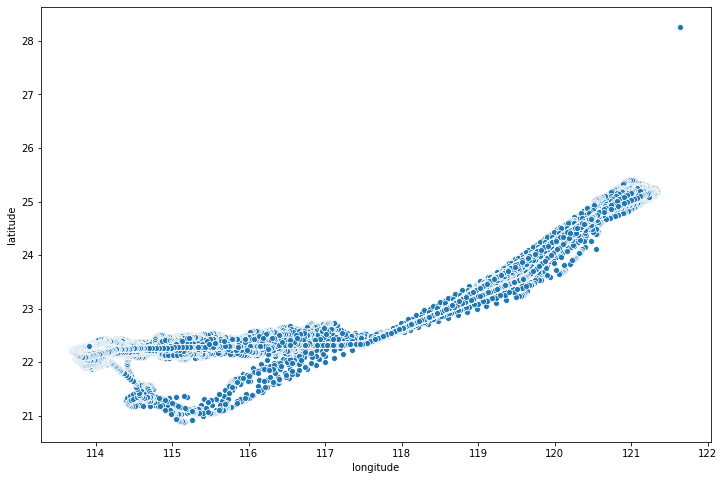

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(ax = ax, x='longitude', y='latitude', data=combined_twn_hkg)
plt.show()

In [86]:
combined_twn_hkg['time_since_real_departure'] = combined_twn_hkg['timestamp_utc'] - combined_twn_hkg['real_departure_utc']

In [87]:
combined_twn_hkg.loc[combined_twn_hkg['latitude'] > 28, trails.columns]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed
27371,c31cf95,1484662603,28.258541,121.633163,11600,8,0


In [88]:
combined_twn_hkg.loc[combined_twn_hkg['flight_id'] == 'c31cf95', 
                     trails.columns].sort_values(by='timestamp_utc').head(5)

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed
27371,c31cf95,1484662603,28.258541,121.633163,11600,8,0
27372,c31cf95,1484662641,24.921299,120.893318,19450,256,0
27373,c31cf95,1484662667,24.853016,120.848541,20684,230,390
27374,c31cf95,1484662677,24.837517,120.830132,21338,219,454
27375,c31cf95,1484662694,24.831850,120.808067,22190,258,329


In [89]:
# Shift latitude and longitude by 1
# for comparison of distance
unique_flight_ids = combined_twn_hkg.flight_id.unique().tolist()

df_prev_lat_lon = pd.DataFrame(columns=['flight_id', 'timestamp_utc', 'prev_latitude', 'prev_longitude'])

for flight_id in unique_flight_ids:
    dummy_df = combined_twn_hkg.loc[combined_twn_hkg['flight_id'] == flight_id, 
                                    ['flight_id', 'timestamp_utc', 'latitude', 'longitude']]
    dummy_df[['latitude', 'longitude']] = dummy_df[['latitude', 'longitude']].shift(1)
    dummy_df.rename(columns={'latitude': 'prev_latitude',
                             'longitude': 'prev_longitude'}, inplace=True)
    df_prev_lat_lon = pd.concat([df_prev_lat_lon, dummy_df])
df_prev_lat_lon

,flight_id,timestamp_utc,prev_latitude,prev_longitude
87466,c0aabc0,1483193923,NaN,NaN
87467,c0aabc0,1483193942,25.089270,121.240158
87468,c0aabc0,1483194080,25.089512,121.240349
87469,c0aabc0,1483194271,25.089546,121.240372
87470,c0aabc0,1483194304,25.089550,121.240372
...,...,...,...,...
227460,c52959e,1485870339,22.308723,113.916298
227461,c52959e,1485870348,22.308483,113.916603
227462,c52959e,1485870355,22.308449,113.916817
227463,c52959e,1485870366,22.308659,113.916946


In [90]:
# print(len(unique_flight_ids))
# df_prev_lat_lon[['prev_latitude', 'prev_longitude']].isnull().sum()

In [91]:
merged_df = pd.merge(combined_twn_hkg,
                     df_prev_lat_lon,
                     how='left',
                     left_on=['flight_id', 'timestamp_utc'],
                     right_on=['flight_id', 'timestamp_utc'])
merged_df.shape

(289649, 34)

In [92]:
# np.array_equal(combined_twn_hkg.flight_id.value_counts().sort_index().values,
#                df_prev_lat_lon.flight_id.value_counts().sort_index().values)

In [93]:
# np.array_equal(combined_twn_hkg.timestamp_utc.tolist(),
#                df_prev_lat_lon.timestamp_utc.tolist())

In [94]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [95]:
selected_col = trails.columns.tolist()
selected_col.extend(['real_flight_duration', 'real_departure_utc', 'real_departure_dt', 
                     'time_since_real_departure'])

**altitude > 0 but speed <= 0. Possibly erroneous**

In [96]:
merged_df.loc[(merged_df['speed'] <= 0) & (merged_df['altitude'] > 0), 
              selected_col]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,time_since_real_departure
142312,c31cf95,1484662603,28.258541,121.633163,11600,8,0,4724.0,1.484662e+09,2017-01-17 22:10:37,366.0
142313,c31cf95,1484662641,24.921299,120.893318,19450,256,0,4724.0,1.484662e+09,2017-01-17 22:10:37,404.0
152134,c33e9e8,1484740426,25.070297,121.248878,50,48,0,5746.0,1.484740e+09,2017-01-18 19:53:45,1.0
152135,c33e9e8,1484740434,25.076294,121.256813,525,50,0,5746.0,1.484740e+09,2017-01-18 19:53:45,9.0
152136,c33e9e8,1484740440,25.079367,121.260925,775,51,0,5746.0,1.484740e+09,2017-01-18 19:53:45,15.0
152416,c33e9e8,1484746201,22.294333,113.895111,50,71,0,5746.0,1.484740e+09,2017-01-18 19:53:45,5776.0
228697,c4490d9,1485359074,24.110689,120.543747,14325,0,0,4663.0,1.485359e+09,2017-01-25 23:37:43,411.0
228698,c4490d9,1485359127,25.075544,120.854759,22050,343,0,4663.0,1.485359e+09,2017-01-25 23:37:43,464.0


In [97]:
merged_df.loc[merged_df['flight_id'] == 'c4490d9'].shape

(35, 34)

In [98]:
merged_df.loc[merged_df['flight_id'] == 'c31cf95', selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,time_since_real_departure
142312,c31cf95,1484662603,28.258541,121.633163,11600,8,0,4724.0,1.484662e+09,2017-01-17 22:10:37,366.0
142313,c31cf95,1484662641,24.921299,120.893318,19450,256,0,4724.0,1.484662e+09,2017-01-17 22:10:37,404.0
142314,c31cf95,1484662667,24.853016,120.848541,20684,230,390,4724.0,1.484662e+09,2017-01-17 22:10:37,430.0
142315,c31cf95,1484662677,24.837517,120.830132,21338,219,454,4724.0,1.484662e+09,2017-01-17 22:10:37,440.0
142316,c31cf95,1484662694,24.831850,120.808067,22190,258,329,4724.0,1.484662e+09,2017-01-17 22:10:37,457.0
142317,c31cf95,1484662709,24.831102,120.788239,22980,287,301,4724.0,1.484662e+09,2017-01-17 22:10:37,472.0
142318,c31cf95,1484662719,24.845474,120.779282,23427,320,348,4724.0,1.484662e+09,2017-01-17 22:10:37,482.0
142319,c31cf95,1484662729,24.866079,120.764854,24134,330,404,4724.0,1.484662e+09,2017-01-17 22:10:37,492.0
142320,c31cf95,1484662736,24.871128,120.760094,24283,319,378,4724.0,1.484662e+09,2017-01-17 22:10:37,499.0
142321,c31cf95,1484662742,24.881048,120.749977,24514,318,374,4724.0,1.484662e+09,2017-01-17 22:10:37,505.0


In [99]:
# Drop flights with flight_id c4490d9, c31cf95. 
# Reason being that the are multiple records with altitude > 0 but speed = 0 in between records
merged_df.drop(merged_df[(merged_df['flight_id'].isin(['c4490d9', 'c31cf95']))].index, inplace=True)

In [100]:
# Don't drop because the records with altitude > 0 but speed = 0
# are at the start of the flight
merged_df.loc[(merged_df['flight_id'] == 'c33e9e8'), 
               selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,time_since_real_departure
152127,c33e9e8,1484740121,25.059814,121.229324,0,225,21,5746.0,1.484740e+09,2017-01-18 19:53:45,-304.0
152128,c33e9e8,1484740373,25.053635,121.227264,0,50,20,5746.0,1.484740e+09,2017-01-18 19:53:45,-52.0
152129,c33e9e8,1484740379,25.054150,121.227951,0,50,46,5746.0,1.484740e+09,2017-01-18 19:53:45,-46.0
152130,c33e9e8,1484740389,25.056210,121.230698,0,50,88,5746.0,1.484740e+09,2017-01-18 19:53:45,-36.0
152131,c33e9e8,1484740399,25.059471,121.234993,0,50,120,5746.0,1.484740e+09,2017-01-18 19:53:45,-26.0
152132,c33e9e8,1484740405,25.061531,121.237564,0,50,140,5746.0,1.484740e+09,2017-01-18 19:53:45,-20.0
152133,c33e9e8,1484740420,25.067184,121.244965,0,49,0,5746.0,1.484740e+09,2017-01-18 19:53:45,-5.0
152134,c33e9e8,1484740426,25.070297,121.248878,50,48,0,5746.0,1.484740e+09,2017-01-18 19:53:45,1.0
152135,c33e9e8,1484740434,25.076294,121.256813,525,50,0,5746.0,1.484740e+09,2017-01-18 19:53:45,9.0
152136,c33e9e8,1484740440,25.079367,121.260925,775,51,0,5746.0,1.484740e+09,2017-01-18 19:53:45,15.0


In [101]:
# merged_df.loc[(merged_df['time_since_real_departure'] >= 0) & 
#               (merged_df['speed'] >= 0), selected_col].sort_values(by='timestamp_utc')

In [102]:
unique_flight_ids = merged_df['flight_id'].unique()
incomplete_flights = []
complete_flights = []
filtered_df = pd.DataFrame(columns=merged_df.columns.tolist() + ['calculated_flight_duration'])

for unique_flight_id in unique_flight_ids:
    # Filter to get records where 
    # plane has taken off; i.e. speed > 0
    # plane's time_since_real_departure >= 0
    temp = merged_df.loc[(merged_df['flight_id'] == unique_flight_id) &
                         (merged_df['time_since_real_departure'] >= 0) 
                         & (merged_df['speed'] > 0)].sort_values(by='timestamp_utc')
#                          , selected_col].sort_values(by='timestamp_utc')
    
    # time_since_real_departure after arrival 
    # where altitude = 0
#     if 0 in temp['altitude'][:10]:
#         print("ZERO ALTITUDE IN FIRST 10")
    possible_arrival_df = temp.loc[(temp['altitude'] == 0) & 
                                   (temp['time_since_real_departure'] > 11)] # setting to 0 will reveal that some planes did not take off successfully at the first attempt; > 0 then back to 0
    
    if possible_arrival_df.shape[0] > 0:
        complete_flights.append(unique_flight_id)
        calculated_flight_duration = possible_arrival_df.iloc[0]['time_since_real_departure']
        temp = temp[temp['time_since_real_departure'] <= calculated_flight_duration]
        temp = temp.assign(calculated_flight_duration=calculated_flight_duration)
        filtered_df = filtered_df.append(temp, ignore_index=True)
    else:
        incomplete_flights.append(unique_flight_id)

print("Number of complete flights: {}".format(len(complete_flights)))
print("Number of incomplete flights: {}".format(len(incomplete_flights)))

Number of complete flights: 788
Number of incomplete flights: 357


In [103]:
filtered_df['calculated_flight_duration'].value_counts().sort_index()

4274.0    141
4503.0    185
4551.0    162
4590.0    176
4593.0    185
         ... 
6781.0    314
6833.0    317
6882.0    281
6930.0    316
6973.0    356
Name: calculated_flight_duration, Length: 632, dtype: int64

In [104]:
# filtered_df[filtered_df['calculated_flight_duration'] == 10]['flight_id'].unique()

In [105]:
# filtered_df[filtered_df['calculated_flight_duration'] == 11]['flight_id'].unique()

In [106]:
# combined_twn_hkg.loc[combined_twn_hkg['flight_id'] == 'c151fba', selected_col] # 283074

In [107]:
# combined_twn_hkg.loc[combined_twn_hkg['flight_id'] == 'c4b371e', selected_col] # 195763

In [108]:
# combined_twn_hkg.loc[combined_twn_hkg['flight_id'] == 'c253ce0', selected_col] # 135054

In [109]:
filtered_df['calculated_time_before_arrival'] = filtered_df['calculated_flight_duration'] - filtered_df['time_since_real_departure']

In [110]:
filtered_df.isnull().sum()

flight_id                              0
timestamp_utc                          0
latitude                               0
longitude                              0
altitude                               0
heading                                0
speed                                  0
flight_callsign                        0
aircraft_model                         0
aircraft_registration                  0
airline                                0
origin                                 0
destination                            0
scheduled_departure_utc                0
scheduled_arrival_utc                  0
real_departure_utc                     0
estimated_arrival_utc             167191
real_flight_duration                3439
scheduled_departure_dt                 0
scheduled_arrival_dt                   0
real_departure_dt                      0
estimated_arrival_dt              167191
scheduled_arrival_year                 0
scheduled_arrival_month                0
scheduled_arriva

In [111]:
# filtered_df[filtered_df['prev_latitude'].isnull() & filtered_df['prev_longitude'].isnull()]

## TEST

In [112]:
# unique_flight_ids = merged_df['flight_id'].unique()
# incomplete_flights_2 = []
# complete_flights_2 = []

# for unique_flight_id in unique_flight_ids:
#     temp = merged_df.loc[(merged_df['flight_id'] == unique_flight_id) &
#                          (merged_df['time_since_real_departure'] >= 0) &
#                          (merged_df['speed'] > 0), 
#                          selected_col].sort_values(by='timestamp_utc')
    
#     # time_since_real_departure after arrival 
#     # where altitude = 0 and time_since_real_departure >= real_flight_duration
#     possible_arrival_df = temp.loc[(temp['time_since_real_departure'] >= temp['real_flight_duration']) &
#                                    (temp['altitude'] == 0)]
    
#     if possible_arrival_df.shape[0] > 0:
#         complete_flights_2.append(unique_flight_id)
#         calculated_flight_duration = possible_arrival_df.iloc[0]['time_since_real_departure']
# #         temp = temp[temp['time_since_real_departure'] < calculated_flight_duration]
#     else:
#         incomplete_flights_2.append(unique_flight_id)
        
# print(len(incomplete_flights_2))

In [113]:
# list(set(incomplete_flights).difference(set(incomplete_flights_2)))

In [114]:
# merged_df.loc[merged_df['flight_id'] == 'c1786da', selected_col]

In [115]:
# merged_df.shape

In [116]:
# merged_df.loc[~merged_df['flight_id'].isin(incomplete_flights)].shape

In [117]:
# merged_df.loc[merged_df['flight_id'].isin(incomplete_flights)].shape

## TEST

In [118]:
# # filter records where time_since_real_departure >= 0 and speed > 0
# # temp = merged_df.loc[(merged_df['flight_id'] == 'c0b73a7') &
# temp = merged_df.loc[(merged_df['flight_id'] == 'c33e9e8') &
#                      (merged_df['time_since_real_departure'] >= 0) &
#                      (merged_df['speed'] > 0), 
#                      selected_col].sort_values(by='timestamp_utc')
# temp.reset_index()

In [119]:
# # time_since_real_departure after arrival 
# # where altitude = 0 and time_since_real_departure >= real_flight_duration
# possible_arrival_df = temp.loc[(temp['time_since_real_departure'] >= temp['real_flight_duration']) &
#                                (temp['altitude'] == 0)]

# possible_arrival_df.shape[0]

In [120]:
# calculated_flight_duration = possible_arrival_df.iloc[0]['time_since_real_departure']
# calculated_flight_duration

In [121]:
# temp[temp['time_since_real_departure'] <= calculated_flight_duration]

In [122]:
# merged_df.columns.sort_values()

In [123]:
# Drop records where time_since_real_departure < 0
# merged_df.drop(merged_df[merged_df['time_since_real_departure'] < 0].index, inplace=True)

In [124]:
# Calculate time before arrival
# merged_df['calculated_time_before_arrival'] = merged_df['real_flight_duration'] - merged_df['time_since_real_departure']

In [125]:
# selected_cols = ['flight_id', 'aircraft_model', 'aircraft_registration', 'airline', 
#                  'flight_callsign', 'heading', 'latitude', 'longitude', 'speed', 'altitude',
#                  'timestamp_utc', 'time_since_real_departure', 'calculated_time_before_arrival']
# merged_df.loc[merged_df['calculated_time_before_arrival'] < 0, selected_cols]

In [126]:
# merged_df.loc[merged_df['flight_id'] == 'c0aabc0', selected_cols]

In [127]:
# Drop records where calculated_time_before_arrival < 0

## Plot of all flights that did not fly a holding pattern (Taiwan Taoyuan International Airport -> Hong Kong International Airport)

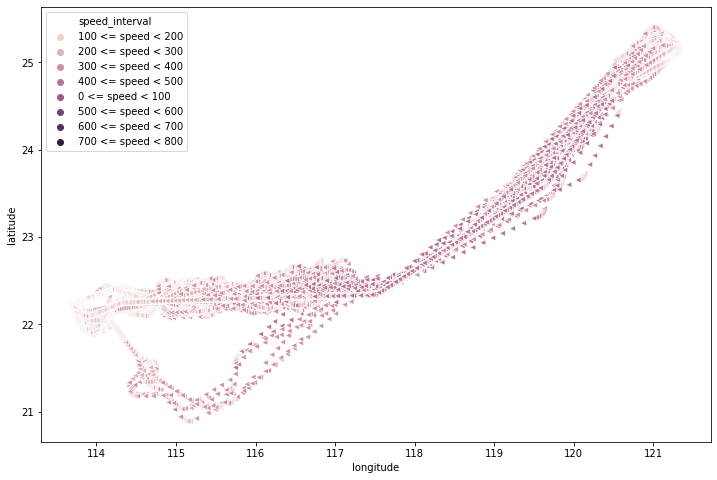

In [128]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(ax = ax, x='longitude', y='latitude', hue='speed_interval', marker='<',
#                 palette=sns.color_palette("Blues", 8),
                palette=sns.cubehelix_palette(8),
                data=filtered_df)
plt.show();

In [129]:
# holding_stack_flight_ids = combined_jkt_sin.loc[combined_jkt_sin['latitude'] > 1.5, 'flight_id'].unique().tolist()

In [130]:
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.scatterplot(ax = ax, x='longitude', y='latitude', hue='speed_interval', marker='<',
# #                 palette=sns.color_palette("Blues", 8),
#                 palette=sns.cubehelix_palette(8),
#                 data=combined_jkt_sin[~combined_jkt_sin['flight_id'].isin(holding_stack_flight_ids)])
# plt.show();

## Plot of all flights that flew a holding pattern (Jakarta Soekarno Hatta International Airport -> Singapore Changi Airport)

In [131]:
# combined_jkt_sin.loc[combined_jkt_sin['flight_id'].isin(holding_stack_flight_ids), 'speed_interval'].unique()

In [132]:
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.scatterplot(ax = ax, x='longitude', y='latitude', hue='speed_interval', marker='<',
# #                 palette=sns.color_palette("Blues", 7),
#                 palette=sns.cubehelix_palette(7),
#                 data=combined_jkt_sin[combined_jkt_sin['flight_id'].isin(holding_stack_flight_ids)])
# plt.show();

In [133]:
# combined_jkt_sin['real_departure'].min()

In [134]:
# combined_jkt_sin['real_departure'].max()

## Modeling

In [135]:
filtered_df.columns

Index(['flight_id', 'timestamp_utc', 'latitude', 'longitude', 'altitude',
       'heading', 'speed', 'flight_callsign', 'aircraft_model',
       'aircraft_registration', 'airline', 'origin', 'destination',
       'scheduled_departure_utc', 'scheduled_arrival_utc',
       'real_departure_utc', 'estimated_arrival_utc', 'real_flight_duration',
       'scheduled_departure_dt', 'scheduled_arrival_dt', 'real_departure_dt',
       'estimated_arrival_dt', 'scheduled_arrival_year',
       'scheduled_arrival_month', 'scheduled_arrival_day',
       'scheduled_departure_year', 'scheduled_departure_month',
       'scheduled_departure_day', 'scheduled_flight_duration', 'route',
       'speed_interval', 'time_since_real_departure', 'prev_latitude',
       'prev_longitude', 'calculated_flight_duration',
       'calculated_time_before_arrival'],
      dtype='object')

In [136]:
selected_features = ['latitude', 'longitude', 'altitude', 'heading', 'speed',
                     'flight_callsign', 'aircraft_model', 'aircraft_registration',
                     'airline']

nominal_features = ['flight_callsign', 'aircraft_model', 'aircraft_registration',
                     'airline']

filtered_df[selected_features].head()

,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline
0,25.090073,121.237190,950,46,143,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo
1,25.093964,121.242012,1375,48,145,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo
2,25.101013,121.251183,2100,50,153,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo
3,25.103577,121.254631,2300,50,159,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo
4,25.107010,121.259155,2525,50,171,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo


In [137]:
def r2_adj(y_true, y_preds, p):
    n = len(y_true)
    y_mean = np.mean(y_true)
    numerator = np.sum(np.square(y_true - y_preds)) / (n - p - 1)
    denominator = np.sum(np.square(y_true - y_mean)) / (n - 1)
    return (1 - (numerator / denominator))

def get_regression_metrics(y_true, y_pred, p):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
#     msle = metrics.mean_squared_log_error(y_true, y_pred)
    mae = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    r2a = r2_adj(y_true, y_pred, p)
    
    print('Mean squared error      = ', mse)
    print('Root mean squared error = ', rmse)
#     print('Mean squared log error  = ', msle)
    print('Median absolute error   = ', mae)
    print('R^2                     = ', r2)
    print('Adjusted R^2            = ', r2a)
    
    return {
        'mse': mse,
        'rmse': rmse,
#         'msle': msle,
        'mae': mae,
        'r2': r2,
        'r2_adjusted': r2a
    }

In [138]:
# Train data

X = filtered_df[selected_features].copy()
y = filtered_df['calculated_time_before_arrival'].copy()

In [139]:
X = pd.get_dummies(X, columns=nominal_features, drop_first=True)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [141]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [142]:
y_train_pred = linreg.predict(X_train)

In [143]:
train_regression_metrics = get_regression_metrics(y_train, y_train_pred, X_train.shape[1])

Mean squared error      =  95747.91005935916
Root mean squared error =  309.4315918896439
Median absolute error   =  197.62673718722363
R^2                     =  0.9739866158679942
Adjusted R^2            =  0.9739125745180442


In [144]:
y_test_pred = linreg.predict(X_test)

In [145]:
test_regression_metrics = get_regression_metrics(y_test, y_test_pred, X_test.shape[1])

Mean squared error      =  94451.16224513613
Root mean squared error =  307.32907809892663
Median absolute error   =  197.11079892898124
R^2                     =  0.9741019745654322
Adjusted R^2            =  0.9738045853501249


In [146]:
df_test_truth_pred = pd.DataFrame(columns=['true', 'pred'])

In [150]:
df_test_truth_pred = df_test_truth_pred.assign(true=y_test)
df_test_truth_pred = df_test_truth_pred.assign(pred=y_test_pred)
df_test_truth_pred['diff'] = df_test_truth_pred['true'] - df_test_truth_pred['pred']

In [153]:
df_test_truth_pred.shape

(34354, 3)

In [152]:
df_test_truth_pred[df_test_truth_pred['diff'] < 0].shape # if true < pred => late

(17640, 3)

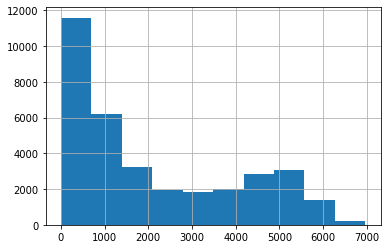

In [149]:
df_test_truth_pred.true.hist()

In [ ]:
df_test_truth_pred.true.